# Idea Behind This Exercisie

The aim of this lab is to give you the tools to read and analyze MATSim results. The library used ([matsim-tools](https://github.com/matsim-vsp/matsim-python-tools)) also provides basic utilities to write MATSim files, which might be useful if you want to modify the input files for your project.

Generating maps and analyses in python or another scripting languages has a few advantages compared to an interactive program, such as VIA:
- it is much more configurable, and in particular makes it quite easy to make comparison between various runs or parts of the day
- by being a script, it can easily be ran for multiple runs

Where VIA shines is interactive analysis, and in particular visualization of movement, rather than aggregate quantities.

Make sure that you install the required packages

#For this class we would need the matsim-tools package and contextily, so you need to pip install it if you haven't already. See below

!pip install matsim-tools

!pip install contextily

In [ ]:
#!python.exe -m pip install 

In [12]:
import matsim
import os
import contextily as ctx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

In [11]:
# scenario_path = "..\\..\\..\\scenarios\\SiouxFalls"
scenario_path = "/Users/Matteo/Library/CloudStorage/OneDrive-ETHZurich/0_Master_REIS/3_Semester/ABMT/Übung/abmt25_own/scenarios/SiouxFalls"

# Network

This section does not contain any exercise, but demonstrates how to read in and visualize the network

In [13]:
# This reads in the network in a structure that contains two tables, one for links and one for nodes.
network = matsim.read_network(os.path.join(scenario_path, "Siouxfalls_network_PT.xml"))

# this creates a geographic dataframe
network_geo = network.as_geo("epsg:26914")

## > How does the df (table) look like?
## > Can we see the different modes of transport in the data?
## > Can we see the coordinates of the links and nodes?
## > Can we plot this network?
## > What coordinate reference system is used here?
## > Can we add a map to the plot?


/opt/miniconda3/envs/jupyter_env/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
network_geo.head()  # shows first rows of the table
network_geo["modes"].unique()  # shows unique modes of transport

0             car
1             car
2             car
3             car
4             car
          ...    
329    car,bus,pt
330    car,bus,pt
331    car,bus,pt
332    car,bus,pt
333    car,bus,pt
Name: modes, Length: 334, dtype: object

<Axes: >

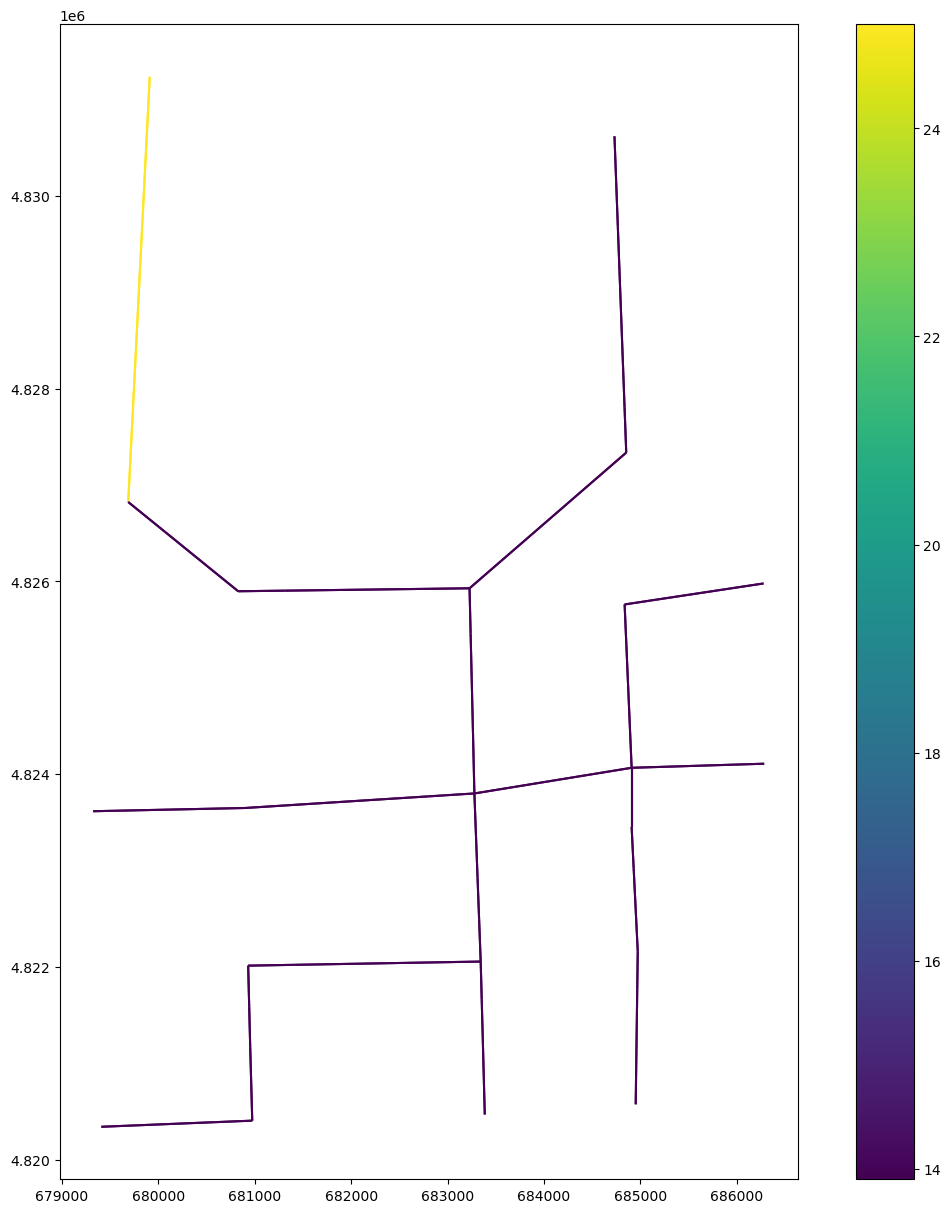

In [14]:
# Geopandas (the library providing geographic dataframes) provides methods to easily plot geographic data
# the network contains lots of links that represent the public transport connections. In the scenario we use,
# all road links have mode "car,car_passenger"
network_geo.query('modes == "car,bus,pt"').plot(
    column="freespeed",
    figsize=(15,15),
    legend=True)

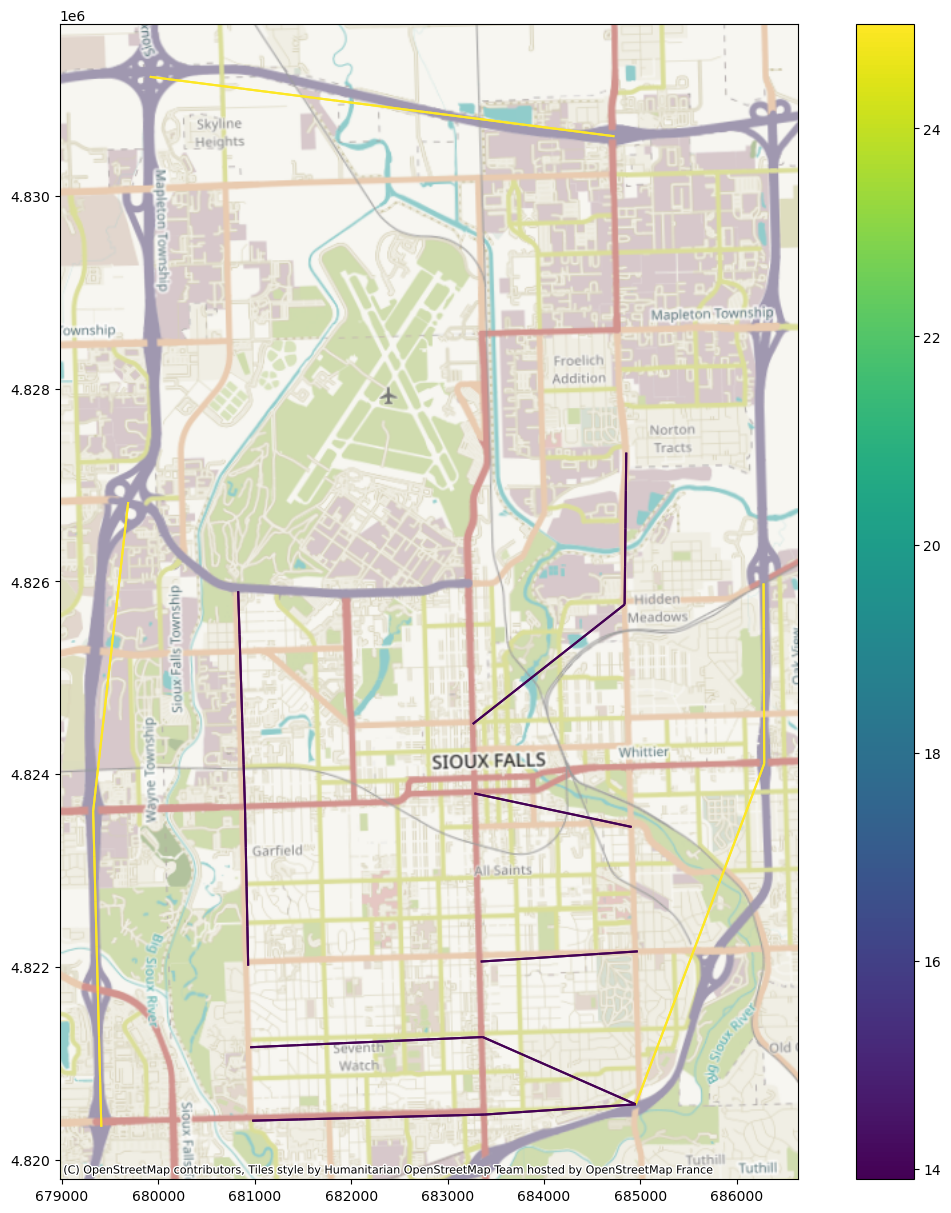

In [9]:
ax = network_geo.query('modes == "car"').plot(
    column="freespeed",
    figsize=(15,15),
    legend=True)

# contextily provides an easy way to add a map background, useful to get context
ctx.add_basemap(ax=ax, crs=network_geo.crs)

# Population

In [ ]:
# The plan reader gives an iterator over the plans in the file
# It actually just provides a way to iterate over the XML elements
plans = matsim.plan_reader(os.path.join(scenario_path, "Siouxfalls_population.xml.gz"))

In [ ]:
# "next" provides one element of the iterator, which we use here to look at how the elements look like.
# The typical way to use an iterator is in a for loop (see below)
first_person, first_plan = next(plans)

In [ ]:
# attrib provides the attributes of the tag, in the XML sense
first_person.attrib

In [ ]:
first_plan.attrib

In [ ]:
# tags that contains elements, such as the plan, are also iterable. The elements can be named differently for example 'activities' instead of 'act'. This allows one to check.
list(first_plan)

In [ ]:
# example of how to create a dataframe with activities
plans = matsim.plan_reader(os.path.join(scenario_path, "Siouxfalls_population.xml.gz"))
## create a list of records (dictionaries) for each activity
## each record should contain the person id, x and y coordinates, and type of activity
## we need to iterate over each person and their plan
## then create a dataframe from that list


In [ ]:
# Transform into a geographic dataframe and plot


## Events

The events are the trace of everything that happens in the simulated physical world, and can be used to produce all kind of analyses. It can be read in a way similar to the plans file.

Events files are typically very big, and it is thus often a good idea to aggregate the information while reading the file. This is demonstrated here.

In [ ]:
#Events in Siouxfall

events = matsim.event_reader(
    '..\\..\\..\\output_counter/output_events.xml.gz',
    # the reader offers a filter of event types for performance.
    # we will parse the file once and extract two tables: traffic counts over per half-day and mode of transport of departures per link
    types='left link,departure')

In [ ]:
# defaultdict creates a value if not there. Here, it creates the default int, which is 0
link_counts = defaultdict(int)
departure_counts = defaultdict(int)

# function to identify the time period based on time of day
def time_period(time_s):
    if time_s < 12 * 3600:
        return "morning"
    return "afternoon"

# iterate through all the events. This takes a little while
for event in events:
    # as for the population, the objects reflect the structure of the XML file
    period = time_period(event["time"])
    link = event["link"]
    
    if event["type"] == "left link":
        link_counts[(link, period)] += 1
    if event["type"] == "departure":
        mode = event["legMode"]
        departure_counts[(link, period, mode)] += 1
        


In [ ]:
len(link_counts)

In [ ]:
len(departure_counts)

In [ ]:
# transform collected data into a data frame
count_table = pd.DataFrame.from_records([
    {'link_id': link, 'period': period, 'link_count': link_count}
    for (link, period), link_count in link_counts.items()
])

#Load siouxfall network file
# This reads in the network in a structure that contains two tables, one for links and one for nodes.
network = matsim.read_network(os.path.join(scenario_path, "Siouxfalls_network_PT.xml"))

# this creates a geographic dataframe
network_geo = network.as_geo()
# merge with network data to be able to produce maps
count_table = network_geo.merge(count_table, on='link_id')
count_table.head()

In [ ]:
# plot counts for the morning period
ax=count_table.query("period == 'morning'").plot(column="link_count", figsize=(15,15), legend=True, cmap="Reds")
ctx.add_basemap(ax, crs=activities_geo.crs)

## Exercise: plot difference in traffic counts between morning and afternoon period

Use the data collected from the events to plot a map of the difference of traffic in the two time periods.
You are free to choose the method you prefer, but here are two suggestions:
- use the "pivot" function (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot)
- split the count table in two tables, one per period, and re-merge them based on the link id. This would emulate how you would do it to compare separate runs, compared to values from the same run